In [1]:
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
from tqdm import tqdm
import os

# For Landmarks:

In [2]:
#ensure that all the columns are read as string
dt = {}
for i in range(6):
    for j in range(6):
        dt[str(i)+str(j)] = str

#load dataframe
df = pd.read_csv("../input/mlware23/dataset/train/train_landmarks.csv", dtype = dt)

In [3]:
df.head(5)

,image,00,01,02,03,04,05,10,11,12,...,42,43,44,45,50,51,52,53,54,55
0,AAHRMrGn0B.jpg,00,35,30,52,15,45,04,05,14,...,55,03,33,43,41,50,31,34,21,11
1,jpEcMy3zDs.jpg,42,34,51,32,13,33,04,10,12,...,40,22,05,43,23,14,41,21,52,35
2,uyDprath60.jpg,50,15,14,13,24,12,53,52,23,...,00,02,55,30,22,05,41,20,43,45
3,k4WEXM5f7C.jpg,21,45,53,20,34,52,15,11,54,...,50,02,42,41,14,43,40,32,25,44
4,lG9bsx1nKj.jpg,12,51,01,13,33,15,20,10,22,...,24,34,25,14,55,44,30,23,35,52


In [4]:
#a function to rearrange the puzzle pieces to their right positions
def rearrange(df, idx):
    img_name = df.loc[idx, "image"]
    im = Image.open("../input/mlware23/dataset/train/landmarks/" + img_name)
    im = np.array(im)
    new_im = np.zeros_like(im)
    cut = im.shape[0]//6
    for i in range(6):
        for j in range(6):
            r, c = int(df.loc[idx, str(i)+str(j)][0]), int(df.loc[idx, str(i)+str(j)][1])
            new_im[r*cut:(r+1)*cut, c*cut:(c+1)*cut] = im[i*cut:(i+1)*cut, j*cut:(j+1)*cut]
    return im, new_im

Text(0.5, 1.0, 'ground_truth')

<Figure size 640x480 with 0 Axes>

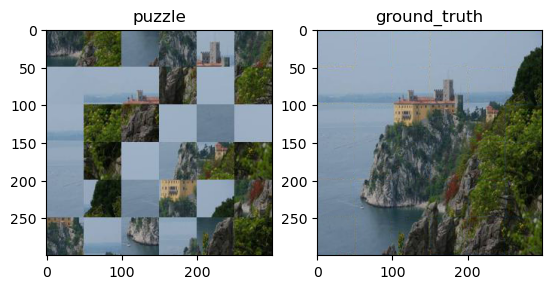

In [5]:
puzzle, solved = rearrange(df, 1)

plt.figure()
f, axarr = plt.subplots(1,2) 
axarr[0].imshow(puzzle)
axarr[0].set_title("puzzle")
axarr[1].imshow(solved)
axarr[1].set_title("ground_truth")

In [6]:
#train test split
n = len(df)
val_split = 0.2
val_df = df[:int(n*val_split)]
train_df = df[int(n*val_split):]

In [7]:
# a function that loads the all the images directly
# each image is cut into 36 puzzle pieces and each piece is stored as a separate array
def load_images(df):
    ret = []
    for idx in tqdm(df.index):
        pieces = []
        img_name = df.loc[idx, "image"]
        img = Image.open("../input/mlware23/dataset/train/landmarks/"+img_name)
        img = np.array(img)
        for i in range(6):
            for j in range(6):
                pieces.append(img[i*50:(i+1)*50, j*50:(j+1)*50])
        ret.append(pieces)
    return np.array(ret)

In [8]:
train_img = load_images(train_df)
val_img = load_images(val_df)

100%|██████████| 600/600 [00:04<00:00, 145.61it/s]


In [9]:
print(train_img.shape)
print(val_img.shape)
type(train_img)
#2400 puzzles, 36 pieces, each piece is a 50x50x3 image

(2400, 36, 50, 50, 3)
(600, 36, 50, 50, 3)


numpy.ndarray

In [10]:
def load_images_faces(df):
    ret = []
    for idx in tqdm(df.index):
        pieces = []
        img_name = df.loc[idx, "image"]
        img = Image.open("../input/mlware23/dataset/train/faces/"+img_name)
        img = np.array(img)
        for i in range(6):
            for j in range(6):
                pieces.append(img[i*50:(i+1)*50, j*50:(j+1)*50])
        ret.append(pieces)
    return np.array(ret)

In [11]:
'''
a function that one hot encodes the given labels.
we have a total of 36 puzzle pieces and 36 possible positions for each of those pieces
if piece at index i has its correct position at index j, we make label[i][j] = 1 
and all the other values in label[i] are set to 0

we iterate through all positions using i and j.
for each position, its index out of 36 will be i*6+j 
and same for the value in that column
'''
def load_labels(df):
    ret = []
    for idx in tqdm(df.index):
        label = np.zeros(shape=(36,36))
        for i in range(6):
            for j in range(6):
                place = i*6 + j
                val = int(df.loc[idx, str(i)+str(j)][0])*6 + int(df.loc[idx, str(i)+str(j)][1])
                label[place][val] = 1
        ret.append(label)
    return np.array(ret)

In [12]:
train_labels = load_labels(train_df)
val_labels = load_labels(val_df)

100%|██████████| 600/600 [00:00<00:00, 1368.12it/s]


In [13]:
print(train_labels.shape)
print(val_labels.shape)
#2400 puzzles, 36x36 one hot encoded matrix as output

(2400, 36, 36)
(600, 36, 36)


# Model Architecture

In [14]:
inp = tf.keras.layers.Input(shape=(36,50,50,3)) #input all puzzle pieces at once

#here we only define the layers and feed the input later
conv1 = tf.keras.layers.Conv2D(8, (3,3), strides=1, padding="same", activation="gelu")
conv2 = tf.keras.layers.Conv2D(16, (3,3), strides=1, padding="same", activation="gelu")
conv3 = tf.keras.layers.Conv2D(8, (3,3), strides=1, padding="same", activation="gelu")
conv4 = tf.keras.layers.Conv2D(8, (3,3), strides=1, padding="same", activation="gelu")
pool0 = tf.keras.layers.MaxPool2D((2, 2))
pool1 = tf.keras.layers.MaxPool2D((2, 2))
pool2 = tf.keras.layers.MaxPool2D((2, 2))
pool3 = tf.keras.layers.MaxPool2D((2, 2))
bn1 = tf.keras.layers.BatchNormalization(axis =-1, epsilon = 1e-4,momentum =0.9)
bn2 = tf.keras.layers.BatchNormalization(axis =-1, epsilon = 1e-4,momentum =0.9)
bn3 = tf.keras.layers.BatchNormalization(axis =-1, epsilon = 1e-4,momentum =0.9)
bn4 = tf.keras.layers.BatchNormalization(axis =-1, epsilon = 1e-4,momentum =0.9)
bn5 = tf.keras.layers.BatchNormalization(axis =-1, epsilon = 1e-4,momentum =0.9)
flat = tf.keras.layers.Flatten()
dense0 = tf.keras.layers.Dense(72, activation="gelu")
drop0 = tf.keras.layers.Dropout(rate=0.5)
drop1 = tf.keras.layers.Dropout(rate=0.2)
dense1 = tf.keras.layers.Dense(36, activation="gelu")

#now we feed each puzzle piece one by one to the layers and store the encodings
mid = []
for i in range(36):
    x = bn3(inp[:, i])
    x = conv1(x) #first dimension is batch_size
    x = bn1(x)
    x = pool0(x)
    x = conv2(x)
    x = bn2(x)
    x = pool2(x)
    x = conv3(x)
    x = bn4(x)
    x = pool1(x)
#     x = conv4(x)
#     x = bn5(x)
#     x = pool3(x)
    x = flat(x)
    x = dense0(x)
    x = drop1(x)
    x = dense1(x)
    mid.append(x)


x = tf.keras.layers.concatenate(mid, axis=-1) #the encodings of all the pieces are concatenated
# x = tf.keras.layers.BatchNormalization(axis=0, epsilon = 1e-4,momentum =0.9)
# x = tf.keras.layers.Dropout(rate=0.2)(x)
# x = tf.keras.layers.Dense(36*36, activation="relu")(x)
x = tf.keras.layers.Reshape((36,36))(x) #the output is reshaped into a 36x36 output
x = tf.keras.layers.Softmax(axis=-1)(x) #softmax to calculate probability

In [15]:
lr_decayed_fn = tf.keras.optimizers.schedules.CosineDecayRestarts(0.01,4)
opt = tf.keras.optimizers.experimental.AdamW(learning_rate=lr_decayed_fn)

In [16]:
model = tf.keras.Model(inputs=inp, outputs=x)
model.compile(optimizer=opt, loss="poisson")

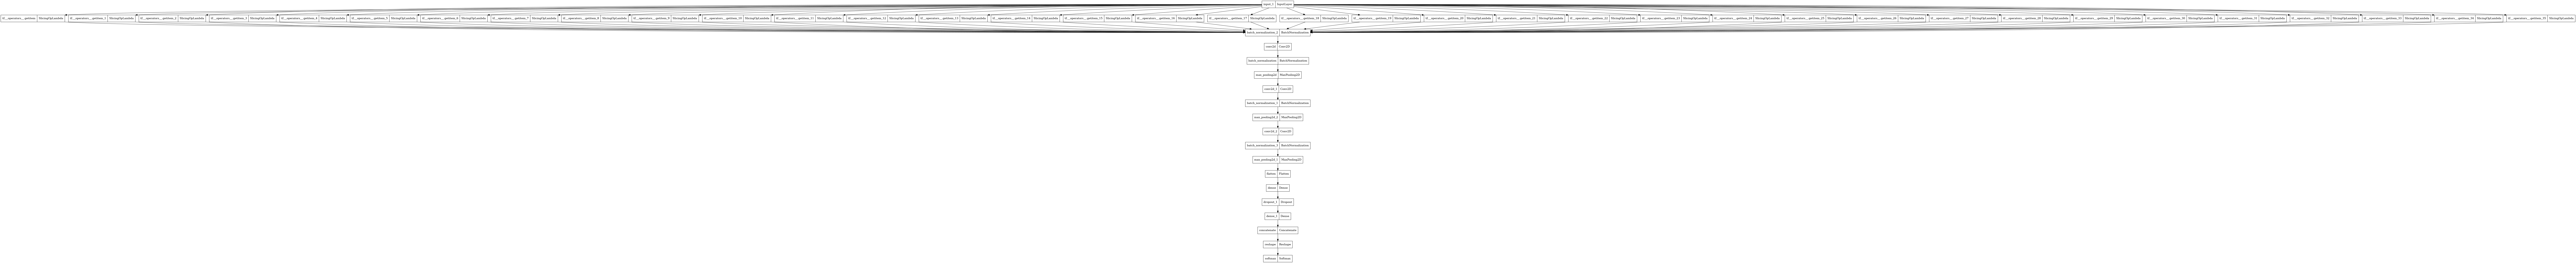

In [17]:
tf.keras.utils.plot_model(model)
# an image of our model architecture
# double click to expand

In [18]:
model.fit(x=train_img, 
          y=train_labels, 
          batch_size=16, 
          validation_data=[val_img, val_labels], 
          shuffle=True,
          epochs=16)

Epoch 1/16
150/150 [==============================] - 42s 100ms/step - loss: 0.1247 - val_loss: 0.1232
Epoch 2/16
150/150 [==============================] - 10s 70ms/step - loss: 0.1224 - val_loss: 0.1215
Epoch 3/16
150/150 [==============================] - 11s 72ms/step - loss: 0.1218 - val_loss: 0.1205
Epoch 4/16
150/150 [==============================] - 11s 70ms/step - loss: 0.1216 - val_loss: 0.1209
Epoch 5/16
150/150 [==============================] - 10s 69ms/step - loss: 0.1212 - val_loss: 0.1201
Epoch 6/16
150/150 [==============================] - 11s 73ms/step - loss: 0.1204 - val_loss: 0.1196
Epoch 7/16
150/150 [==============================] - 10s 69ms/step - loss: 0.1201 - val_loss: 0.1202
Epoch 8/16
150/150 [==============================] - 10s 70ms/step - loss: 0.1206 - val_loss: 0.1203
Epoch 9/16
150/150 [==============================] - 11s 72ms/step - loss: 0.1202 - val_loss: 0.1192
Epoch 10/16
150/150 [==============================] - 10s 70ms/step - loss: 0.11

In [19]:
pred = model.predict(val_img)
pred = np.argmax(pred, axis=-1)

19/19 [==============================] - 4s 23ms/step


In [20]:
print(pred.shape)
print(pred)
# 600 puzzles, 36 predicted permutations

(600, 36)
[[ 8 15 15 ... 21 21 20]
 [24 29 13 ...  7 24 35]
 [34  4  4 ...  8 21 21]
 ...
 [ 3 31 13 ... 21  0 27]
 [28 19 30 ... 10  3  3]
 [35 21 18 ... 30 30 26]]


In [21]:
print(pred[0])
#predicted permutation for 0th puzzle

[ 8 15 15 21 16 14 21 33 15 15 20 14 15 16 32 19 20 15 25 28 34 15 26 16
 21 21 19 32 15 15 21 31 21 21 21 20]


In [22]:
#formatting our predictions into pandas dataframe
pred_list = []
for i in range(pred.shape[0]):
    t = []
    for j in range(pred[i].shape[0]):
        t.append(str(pred[i][j]//6) + str(pred[i][j]%6))
    pred_list.append(t)

image_df = pd.DataFrame(val_df["image"])
label_df = pd.DataFrame(pred_list)
out = pd.concat([image_df, label_df], axis=1)
out.columns = df.columns

In [23]:
out

,image,00,01,02,03,04,05,10,11,12,...,42,43,44,45,50,51,52,53,54,55
0,AAHRMrGn0B.jpg,12,23,23,33,24,22,33,53,23,...,31,52,23,23,33,51,33,33,33,32
1,jpEcMy3zDs.jpg,40,45,21,40,23,41,03,03,12,...,00,43,12,31,32,02,41,11,40,55
2,uyDprath60.jpg,54,04,04,04,13,12,52,43,13,...,00,03,41,22,32,03,32,12,33,33
3,k4WEXM5f7C.jpg,23,52,54,02,22,53,03,12,51,...,50,02,42,52,12,44,41,22,13,50
4,lG9bsx1nKj.jpg,42,42,12,22,22,13,12,12,33,...,33,33,13,32,33,33,32,22,33,44
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,A56b5f2HB9.jpg,33,41,32,33,33,42,32,41,43,...,41,33,33,52,22,22,32,44,32,40
596,cVWTsoiKGL.jpg,03,44,32,03,23,03,12,23,03,...,53,51,40,13,43,51,51,32,41,51
597,2JZtpRAsUn.jpg,03,51,21,52,33,40,02,51,44,...,44,42,02,44,54,12,53,33,00,43
598,2eFscbTZ5I.jpg,44,31,50,03,12,42,04,33,03,...,40,03,30,32,41,30,41,14,03,03


Text(0.5, 1.0, 'predicted')

<Figure size 640x480 with 0 Axes>

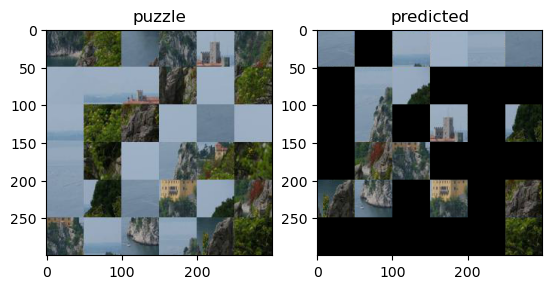

In [24]:
puzzle, predicted = rearrange(out, 1)

plt.figure()
f, axarr = plt.subplots(1,2) 
axarr[0].imshow(puzzle)
axarr[0].set_title("puzzle")
axarr[1].imshow(predicted)
axarr[1].set_title("predicted")
#predictions are bad as expected

# Inference for Landmarks:

In [25]:
def load_images_landmarks_test(names):
    ret = []
    for idx, _ in tqdm(enumerate(names)):
        pieces = []
        img_name = names[idx]
        img = Image.open("../input/mlware23/dataset/test/landmarks/"+img_name)
        img = np.array(img)
        for i in range(6):
            for j in range(6):
                pieces.append(img[i*50:(i+1)*50, j*50:(j+1)*50])
        ret.append(pieces)
    return np.array(ret)

In [26]:
landmark_names = os.listdir("/kaggle/input/mlware23/dataset/test/landmarks")
len(landmark_names)

1096

In [27]:
test_imgs_lm = load_images_landmarks_test(landmark_names)
test_imgs_lm.shape

1096it [00:06, 158.81it/s]


(1096, 36, 50, 50, 3)

In [28]:
pred_test_lm = model.predict(test_imgs_lm)
pred_test_lm = np.argmax(pred_test_lm, axis=-1)

35/35 [==============================] - 1s 22ms/step


In [29]:
print(pred_test_lm.shape)
print(pred_test_lm)

(1096, 36)
[[ 8 10 15 ...  5 20 14]
 [20 21 20 ... 20 20 20]
 [19  2 31 ... 13 23  0]
 ...
 [10  5 24 ... 31 15 24]
 [16 10 31 ...  4  5 13]
 [18  3 17 ... 32 33 32]]


# For Faces:

In [30]:
df_faces = pd.read_csv("../input/mlware23/dataset/train/train_faces.csv", dtype = dt)

In [31]:
df_faces.head()

,image,00,01,02,03,04,05,10,11,12,...,42,43,44,45,50,51,52,53,54,55
0,hwJUKjziH0.jpg,22,20,14,04,43,40,35,53,25,...,31,41,13,32,33,10,02,30,50,44
1,smzyIVQ4Ve.jpg,03,50,43,14,05,13,33,52,01,...,41,35,45,30,44,22,51,00,32,15
2,IT3H2QbaJY.jpg,55,25,43,10,33,20,22,13,54,...,00,42,11,41,12,23,30,51,35,32
3,Yceag6Ca0B.jpg,12,32,52,05,15,42,55,04,10,...,34,20,13,21,22,45,33,41,23,35
4,nDBcp5ZyPj.jpg,33,44,12,45,50,54,20,24,00,...,55,34,04,25,52,15,11,21,02,32


In [32]:
#train test split for faces
n = len(df_faces)
val_split = 0.05
val_df_faces = df_faces[:int(n*val_split)]
train_df_faces = df_faces[int(n*val_split):]

In [33]:
train_img_faces = load_images_faces(train_df_faces)
val_img_faces = load_images_faces(val_df_faces)

100%|██████████| 4/4 [00:00<00:00, 154.78it/s]


In [34]:
print(train_img_faces.shape)
print(val_img_faces.shape)
type(train_img_faces)

(95, 36, 50, 50, 3)
(4, 36, 50, 50, 3)


numpy.ndarray

In [35]:
train_labels_faces = load_labels(train_df_faces)
val_labels_faces = load_labels(val_df_faces)

100%|██████████| 4/4 [00:00<00:00, 522.17it/s]


In [36]:
print(train_labels_faces.shape)
print(val_labels_faces.shape)

(95, 36, 36)
(4, 36, 36)


In [37]:
model.fit(x=train_img_faces, 
          y=train_labels_faces, 
          batch_size=16, 
          validation_data=[val_img_faces, val_labels_faces], 
          shuffle=True,
          epochs=5)

Epoch 1/5
6/6 [==============================] - 19s 101ms/step - loss: 0.1260 - val_loss: 0.1170
Epoch 2/5
6/6 [==============================] - 0s 84ms/step - loss: 0.1213 - val_loss: 0.1139
Epoch 3/5
6/6 [==============================] - 0s 84ms/step - loss: 0.1185 - val_loss: 0.1109
Epoch 4/5
6/6 [==============================] - 0s 82ms/step - loss: 0.1150 - val_loss: 0.1094
Epoch 5/5
6/6 [==============================] - 1s 87ms/step - loss: 0.1127 - val_loss: 0.1073


In [38]:
pred_faces = model.predict(val_img_faces)
pred_faces = np.argmax(pred_faces, axis=-1)

1/1 [==============================] - 0s 37ms/step


In [39]:
#formatting our predictions into pandas dataframe
pred_list_faces = []
for i in range(pred_faces.shape[0]):
    t = []
    for j in range(pred_faces[i].shape[0]):
        t.append(str(pred_faces[i][j]//6) + str(pred_faces[i][j]%6))
    pred_list_faces.append(t)

image_df_faces = pd.DataFrame(val_df_faces["image"])
label_df_faces = pd.DataFrame(pred_list_faces)
out_faces = pd.concat([image_df_faces, label_df_faces], axis=1)
out_faces.columns = df_faces.columns

In [40]:
def rearrange_faces(df, idx):
    img_name = df.loc[idx, "image"]
    im = Image.open("../input/mlware23/dataset/train/faces/" + img_name)
    im = np.array(im)
    new_im = np.zeros_like(im)
    cut = im.shape[0]//6
    for i in range(6):
        for j in range(6):
            r, c = int(df.loc[idx, str(i)+str(j)][0]), int(df.loc[idx, str(i)+str(j)][1])
            new_im[r*cut:(r+1)*cut, c*cut:(c+1)*cut] = im[i*cut:(i+1)*cut, j*cut:(j+1)*cut]
    return im, new_im

In [41]:
out_faces

,image,00,01,02,03,04,05,10,11,12,...,42,43,44,45,50,51,52,53,54,55
0,hwJUKjziH0.jpg,12,40,35,41,43,40,02,12,01,...,43,43,43,32,32,40,12,21,40,21
1,smzyIVQ4Ve.jpg,02,40,33,45,02,13,33,32,01,...,32,35,34,50,24,33,41,00,32,05
2,IT3H2QbaJY.jpg,40,25,32,54,42,35,23,04,53,...,54,42,21,40,51,23,51,10,14,23
3,Yceag6Ca0B.jpg,12,32,05,54,54,42,01,02,54,...,53,54,12,21,32,54,33,40,33,05


Text(0.5, 1.0, 'predicted')

<Figure size 640x480 with 0 Axes>

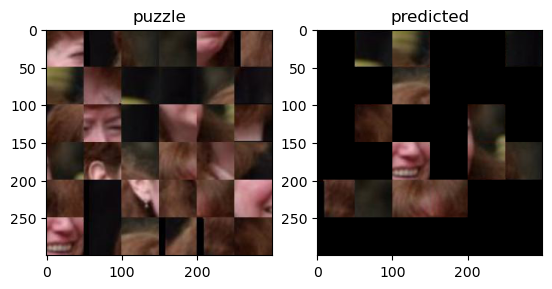

In [42]:
puzzle, predicted = rearrange_faces(out_faces, 0)

plt.figure()
f, axarr = plt.subplots(1,2) 
axarr[0].imshow(puzzle)
axarr[0].set_title("puzzle")
axarr[1].imshow(predicted)
axarr[1].set_title("predicted")

# Inference for Faces:

In [43]:
def prediction_to_submission(df):
    df = df.copy()
    for s in ['r','c']:
        for i in range(6):
            for j in range(6):
                df[str(s)+str(i)+str(j)] = None

    for idx in df.index:
        for i in range(6):
            for j in range(6):
                df.loc[idx, 'r'+str(i)+str(j)] = int(df.loc[idx, str(i)+str(j)][0])
                df.loc[idx, 'c'+str(i)+str(j)] = int(df.loc[idx, str(i)+str(j)][1])

    columns_to_remove = []
    for i in range(6):
        for j in range(6):
            columns_to_remove.append(str(i)+str(j))

    return df.drop(columns=columns_to_remove)

In [44]:
faces_names = os.listdir("/kaggle/input/mlware23/dataset/test/faces")
len(faces_names)

900

In [45]:
def load_images_faces_test(names):
    ret = []
    for idx, _ in tqdm(enumerate(names)):
        pieces = []
        img_name = names[idx]
        img = Image.open("../input/mlware23/dataset/test/faces/"+img_name)
        img = np.array(img)
        for i in range(6):
            for j in range(6):
                pieces.append(img[i*50:(i+1)*50, j*50:(j+1)*50])
        ret.append(pieces)
    return np.array(ret)

In [46]:
test_imgs_faces = load_images_faces_test(faces_names)
test_imgs_faces.shape

900it [00:05, 165.13it/s]


(900, 36, 50, 50, 3)

In [47]:
pred_test_faces = model.predict(test_imgs_faces)
pred_test_faces = np.argmax(pred_test_faces, axis=-1)

29/29 [==============================] - 1s 22ms/step


In [48]:
print(pred_test_faces.shape)
print(pred_test_faces)

(900, 36)
[[14 21 35 ... 35  8 25]
 [29  0  0 ... 14  8 19]
 [30  5  6 ... 33 19 19]
 ...
 [ 7 19 35 ... 10 21  8]
 [21  8 25 ... 22 27 22]
 [ 0  8 27 ...  0 16  4]]


# Concatenating Both Inferences

In [49]:
pred_test = np.concatenate((pred_test_faces, pred_test_lm), axis=0)
pred_test.shape

(1996, 36)

In [50]:
total_names = np.concatenate((faces_names, landmark_names), axis=0)
test_df = pd.DataFrame(total_names, columns=["image"])
test_df["image"]

0       WGQXHxMR9O.jpg
1       9U8qCFtbm6.jpg
2       5c226K9FPa.jpg
3       gQZ2RkWph6.jpg
4       CKQKTWgIWM.jpg
             ...      
1991    LtSWXrsNf9.jpg
1992    u7hsNtpX0P.jpg
1993    bPnwug5C6l.jpg
1994    lzz6bPFDjZ.jpg
1995    DHCBHTt06Q.jpg
Name: image, Length: 1996, dtype: object

In [51]:
pred_test_list = []
for i in range(pred_test.shape[0]):
    t = []
    for j in range(pred_test[i].shape[0]):
        t.append(str(pred_test[i][j]//6) + str(pred_test[i][j]%6))
    pred_test_list.append(t)

image_test_df = pd.DataFrame(test_df["image"])
label_test_df = pd.DataFrame(pred_test_list)
out_test = pd.concat([image_test_df, label_test_df], axis=1)
out_test.columns = df.columns

In [52]:
out_test

,image,00,01,02,03,04,05,10,11,12,...,42,43,44,45,50,51,52,53,54,55
0,WGQXHxMR9O.jpg,22,33,55,45,12,31,35,55,01,...,31,55,25,41,21,42,24,55,12,41
1,9U8qCFtbm6.jpg,45,00,00,00,00,12,00,31,45,...,42,45,33,23,33,23,32,22,12,31
2,5c226K9FPa.jpg,50,05,10,33,10,24,04,00,53,...,10,01,40,12,12,33,42,53,31,31
3,gQZ2RkWph6.jpg,12,55,40,22,40,54,51,12,13,...,02,54,40,21,54,21,41,00,43,04
4,CKQKTWgIWM.jpg,32,34,42,21,53,55,34,01,22,...,11,12,12,13,41,01,11,24,55,55
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1991,LtSWXrsNf9.jpg,04,12,22,12,50,03,33,03,32,...,03,33,00,55,30,33,40,03,44,03
1992,u7hsNtpX0P.jpg,30,00,00,43,00,31,00,50,50,...,32,50,32,50,32,50,50,04,00,30
1993,bPnwug5C6l.jpg,14,05,40,42,23,33,33,43,41,...,32,05,53,33,22,32,32,51,23,40
1994,lzz6bPFDjZ.jpg,24,14,51,04,24,04,32,05,14,...,05,05,42,23,14,05,05,04,05,21


In [53]:
def rearrange_test(df, idx):
    img_name = df.loc[idx, "image"]
    if idx < 1096:
        s = "faces"
    else:
        s = "landmarks"
    im = Image.open("../input/mlware23/dataset/test/"+s+"/" + img_name)
    im = np.array(im)
    new_im = np.zeros_like(im)
    cut = im.shape[0]//6
    for i in range(6):
        for j in range(6):
            r, c = int(df.loc[idx, str(i)+str(j)][0]), int(df.loc[idx, str(i)+str(j)][1])
            new_im[r*cut:(r+1)*cut, c*cut:(c+1)*cut] = im[i*cut:(i+1)*cut, j*cut:(j+1)*cut]
    return im, new_im

Text(0.5, 1.0, 'predicted')

<Figure size 640x480 with 0 Axes>

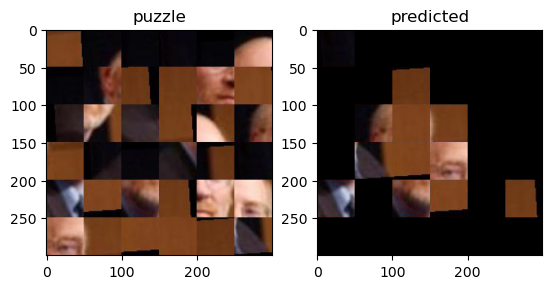

In [54]:
puzzle, predicted = rearrange_test(out_test, 1)

plt.figure()
f, axarr = plt.subplots(1,2) 
axarr[0].imshow(puzzle)
axarr[0].set_title("puzzle")
axarr[1].imshow(predicted)
axarr[1].set_title("predicted")

In [55]:
final_submission=prediction_to_submission(out_test)

In [56]:
final_submission

,image,r00,r01,r02,r03,r04,r05,r10,r11,r12,...,c42,c43,c44,c45,c50,c51,c52,c53,c54,c55
0,WGQXHxMR9O.jpg,2,3,5,4,1,3,3,5,0,...,1,5,5,1,1,2,4,5,2,1
1,9U8qCFtbm6.jpg,4,0,0,0,0,1,0,3,4,...,2,5,3,3,3,3,2,2,2,1
2,5c226K9FPa.jpg,5,0,1,3,1,2,0,0,5,...,0,1,0,2,2,3,2,3,1,1
3,gQZ2RkWph6.jpg,1,5,4,2,4,5,5,1,1,...,2,4,0,1,4,1,1,0,3,4
4,CKQKTWgIWM.jpg,3,3,4,2,5,5,3,0,2,...,1,2,2,3,1,1,1,4,5,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1991,LtSWXrsNf9.jpg,0,1,2,1,5,0,3,0,3,...,3,3,0,5,0,3,0,3,4,3
1992,u7hsNtpX0P.jpg,3,0,0,4,0,3,0,5,5,...,2,0,2,0,2,0,0,4,0,0
1993,bPnwug5C6l.jpg,1,0,4,4,2,3,3,4,4,...,2,5,3,3,2,2,2,1,3,0
1994,lzz6bPFDjZ.jpg,2,1,5,0,2,0,3,0,1,...,5,5,2,3,4,5,5,4,5,1


In [57]:
final_submission.to_csv("submission.csv", index=False)